In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
%matplotlib inline

os.chdir('..\..\..\..')
print(os.getcwd())

# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(), 'configuration/input_configuration.toml'))

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


C:\workspace\Joanne\change_toml\soundcast


In [2]:
working_dir = r'outputs/agg/dash'
# pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///inputs/db/soundcast_inputs.db',
        columns=['CountyName','ParcelID'])

# Usual School Distance

In [5]:
person = pd.read_csv(r'outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [6]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pspcl', right_on='ParcelID', how='left')

In [7]:
person['wt_psautime'] = person['psautime']*person['psexpfac']
person['wt_psaudist'] = person['psaudist']*person['psexpfac']

### Average Distance for **All Students**

In [8]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     4.343263
survey    4.970066
dtype: float64

#### Average Distance by School County

In [9]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.636042,4.869694
Kitsap,3.871993,5.084389
Pierce,4.320561,3.757325
Snohomish,3.642247,6.957565


### Average Distance for **University** Students only

In [10]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 5)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model      6.228582
survey    10.074345
dtype: float64

#### Average Distance by School County

In [11]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,6.026377,8.175139
Kitsap,7.556397,10.788048
Pierce,6.289814,8.544986
Snohomish,6.786725,18.596234


#### Top 10 University TAZs

In [12]:
_df = person_survey[person_survey['pptyp'] == 5]
_df = _df[_df['psaudist'] > 0]
# Top 10 College Destinations
n = 10
top10_college = _df['pstaz'].value_counts()[:n].index.tolist()

_df['wt_psaudist'] = _df['psaudist']*_df['psexpfac']
survey_avg = _df[_df['pstaz'].isin(top10_college)].groupby('pstaz').sum()[['psexpfac','wt_psaudist']]
survey_avg['average_survey'] = survey_avg['wt_psaudist']/survey_avg['psexpfac']

# add survey count as we;ll
person_count = person_survey[(person_survey['pptyp'] == 5) & (person_survey['psaudist'] >0)]
person_count = person_count.groupby('pstaz').count()[['hhno']].reset_index()
person_count.rename(columns={'hhno': 'sample_count'}, inplace=True)
survey_avg = survey_avg.merge(person_count, left_index=True, right_on='pstaz')

In [13]:
model_avg = person[person['pptyp'] == 5]
model_avg = model_avg[model_avg['psaudist'] > 0]
model_avg = model_avg[model_avg['pstaz'].isin(top10_college)].groupby('pstaz').sum()[['psexpfac','psaudist']]
model_avg['average_model'] = model_avg['psaudist']/model_avg['psexpfac']
model_avg = model_avg.reset_index()

In [14]:
_df = model_avg[['average_model','pstaz']].merge(survey_avg[['average_survey','sample_count','pstaz']], on='pstaz')
# _df[~_df.average_survey.isnull()]
_df

,average_model,pstaz,average_survey,sample_count
0,3.010065,72,1.095581,4
1,4.204142,302,3.842871,85
2,0.054577,303,3.148578,23
3,0.022707,304,8.839913,21
4,0.064921,305,1.180015,5
5,0.061153,340,2.201191,8
6,4.464709,552,4.347698,8
7,3.767684,584,2.870651,10
8,4.636151,756,2.640770,4
9,4.563086,1798,24.735015,5


#### Average Distance for **High School Students 16+** 

In [15]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 6)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     4.649358
survey    5.315163
dtype: float64

In [16]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.795621,6.343142
Kitsap,3.847079,5.394562
Pierce,4.796165,1.988059
Snohomish,4.339173,3.717452


### Average Distance for **Kids Age 5-15**

In [17]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pptyp'] == 7)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     2.603638
survey    3.408273
dtype: float64

#### Average Distance by School County

In [18]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,2.553202,3.557559
Kitsap,2.700511,4.686768
Pierce,2.649451,3.046646
Snohomish,2.645475,2.481274


## Usual School Location Distance Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Students

<AxesSubplot:xlabel='psaudist_bin'>

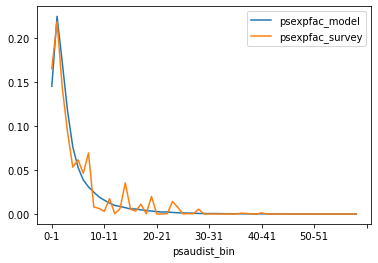

In [19]:
# Create bins
max_bin = 60
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

In [20]:
range(0,max_bin,5)

range(0, 60, 5)

<AxesSubplot:xlabel='psaudist_bin'>

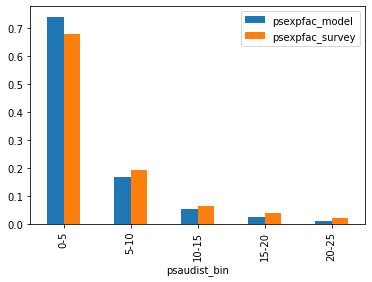

In [21]:
# Create bins
max_bin = 30
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,5)])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

### College Student Usual School Distance

College Students: 160991


<AxesSubplot:xlabel='psaudist_bin'>

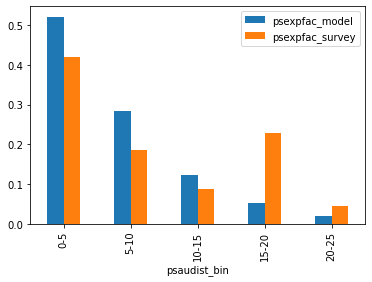

In [22]:
# By studnet type (persontype == 5, 6, 7 )
max_bin = 30
ptype = 5
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('College Students: ' + str(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')

### High School Student 16+ School Distance

High School Students 16+: 160857


<AxesSubplot:xlabel='psaudist_bin'>

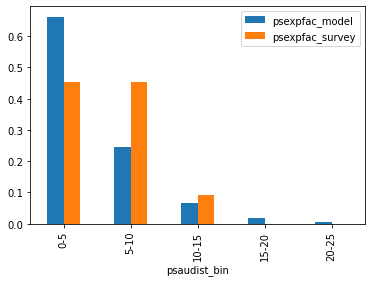

In [23]:
# By studnet type (persontype == 5, 6, 7 )
max_bin = 30
ptype = 6
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('High School Students 16+: ' + str(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')

### Age 5-15 Student School Distance

Students Age 5-15: 519956


<AxesSubplot:xlabel='psaudist_bin'>

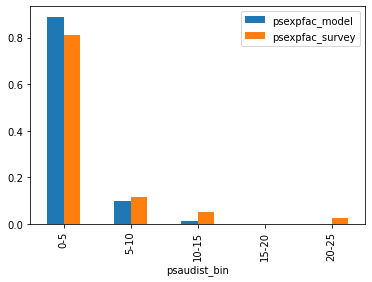

In [24]:
# By studnet type (persontype == 5, 6, 7 )
max_bin = 30
ptype = 7
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,int(max_bin/6))])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0) & (person['pptyp'] == ptype)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
print('Students Age 5-15: ' + str(len(person[person['pptyp'] == ptype])))
df.plot(kind='bar')